In [51]:
%pylab inline
from pytrends.request import TrendReq
from datetime import date
import requests
import json
from io import StringIO
import plotly.express as px
import ipywidgets as widgets
from datetime import datetime, date
import pandas as pd
import imageio
import sys, os
import imageio
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# hllist = ["it", "ja", "en", "fr", "de"] 
# cat for Infectious Diseases: 632
# cat for Cold & Flu: 629

pytrend = TrendReq(hl='it-IT', tz=0, timeout=(10,25), retries=2, backoff_factor=0.1)

codes = {"IT-65":"Abruzzo",
"IT-77":"Basilicata",
"IT-78":"Calabria",
"IT-72":"Campania",
"IT-45":"Emilia-Romagna",
"IT-62":"Lazio",
"IT-42":"Liguria",
"IT-25":"Lombardia",
"IT-57":"Marche",
"IT-67":"Molise",
"IT-21":"Piemonte",
"IT-75":"Puglia",
"IT-52":"Toscana",
"IT-55":"Umbria",
"IT-34":"Veneto",
"IT-36":"Friuli-Venezia Giulia",
"IT-88":"Sardegna",
"IT-82":"Sicilia",
"IT-32":"Trentino-Alto Adige/Südtirol",
"IT-23":"Valle d'Aosta/Vallée d'Aoste",
   "IT":"Italia"}

regs = dict(map(reversed, codes.items()))


Populating the interactive namespace from numpy and matplotlib


/Users/annette/.local/share/virtualenvs/covid-8MZFs_Ml/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['f', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy



# Get Pietro's normalized data

In [119]:
# use data from pietro
import pickle
folder = "trends_downloader_and_data/"
with open(folder + "it_raw_data_ibr_w_old.p", 'rb') as f:
    it_ibr = pickle.load(f)
with open(folder + "raw_data_ibr_w_old.p", 'rb') as f:
    ibr = pickle.load(f)


df = pd.concat(ibr.values(), keys=ibr.keys())
df.index.names = ["region", "date"]
df=df.reset_index()
df['reg_name']=[codes[r["region"]] for i,r in df.iterrows()]
df_log = df.replace(0, 1)
df["coronavirus_log"] = np.log10(df_log["coronavirus"])

#remove inf??
df = df.replace([np.inf, -np.inf], np.nan)

start_date = datetime(2020, 1, 20)
end_date = datetime(2020, 4, 8)
available_dates = pd.date_range(start=start_date, end=end_date, freq='D')

df_list={}
date_list=[]
for date in available_dates:
    date_list.append(date.strftime("%d/%m/%Y"))
    df_list[date.strftime("%d/%m/%Y")] = df.loc[df["date"] == date]
df_list[date.strftime("%d/%m/%Y")].head()
df.describe()
df.head()


,region,date,coronavirus,reg_name,coronavirus_log
0,IT-65,2020-01-01,0.0,Abruzzo,0.0
1,IT-65,2020-01-02,0.0,Abruzzo,0.0
2,IT-65,2020-01-03,0.0,Abruzzo,0.0
3,IT-65,2020-01-04,0.0,Abruzzo,0.0
4,IT-65,2020-01-05,0.0,Abruzzo,0.0


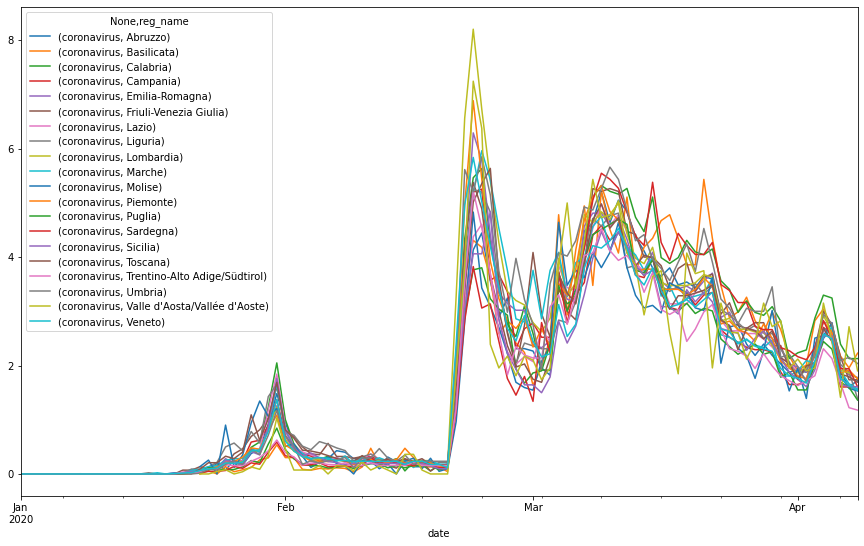

In [120]:

piv = pd.pivot_table(df, index=['date'],columns=['reg_name'], values=['coronavirus'])
piv.plot(figsize=(15,9))

# Geojson

In [4]:
URL_regions_geojson="https://github.com/openpolis/geojson-italy/raw/master/geojson/limits_IT_regions.geojson"

def get_geojson_url(url):
    try: 
        s=requests.get(url)
        return json.load(StringIO(s.text))
    except exception as e:
        # Need to check its an 404, 503, 500, 403 etc.
        print("http error %s" % e.response.status_code)

geojson_region = get_geojson_url(URL_regions_geojson)

for g in geojson_region['features']:
    g['id']=regs[g['properties']['reg_name']]

#{'reg_name': 'Piemonte', 'reg_istat_code_num': 1, 'reg_istat_code': '01'}
# region_properties
geojson_region["features"][0]["properties"]

{'reg_name': 'Piemonte', 'reg_istat_code_num': 1, 'reg_istat_code': '01'}

# Plot map

In [98]:
# helper function for when we produce the frames for the map animation
def frame_args(duration):
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear"},
    }

In [123]:
fig = make_subplots(rows=2, cols=1, specs=[[{"type": "scattergeo"}], [{"type": "xy"}]], row_heights=[0.8, 0.2])


# set up the geo data, the slider, the play and pause buttons, and the title
fig.layout.geo = {"showcountries": False, "fitbounds":"locations", "visible": False}
fig.layout.sliders = [{"active": 0, "steps": []}]
fig.layout.updatemenus = [
    {
        "type": "buttons",
        "buttons": [
            {
                "label": "&#9654;",  # play symbol
                "method": "animate",
                "args": [None, frame_args(250)],
            },
            {
                "label": "&#9724;",
                "method": "animate",  # stop symbol
                "args": [[None], frame_args(0)],
            },
        ],
        "showactive": False,
        "direction": "left",
    }
]
fig.layout.title = {"text": "Google Seachers for Coronavirus ", "x": 0.5}


frames = []
steps = []
high = int(df["coronavirus"].max())
low = 0
tick_values = list(range(low, high))
visual_tick_values = tick_values



# this loop generates the data for each frame
for i, (date, data) in enumerate(df_list.items(), start=1):
    gdf = data
    strdate = date
    #.loc[row_indexer,col_indexer] = value instead
    gdf.loc[:,"text"] = (
        strdate
        + "<br>"
        + gdf["reg_name"]
        + "<br>Searches: "
        + gdf["coronavirus"].apply(lambda x: "{:,}".format(x))
    )
    
    # create the choropleth chart
    choro_trace = go.Choropleth(
        **{
            "geojson": geojson_region,
            "locations": gdf["region"],
            "z": gdf["coronavirus"],
            "zmax": high,
            "zmin": low,
            "colorscale": "Plasma",
            "colorbar": {
                "ticks": "outside",
                "ticktext": visual_tick_values,
                "tickmode": "array",
                "tickvals": tick_values,
                "title": {"text": "<b>Coronavirus</b>"},
                "len": 0.8,
                "y": 1,
                "yanchor": "top"
            },
            "hovertemplate": gdf["text"],
            "name": "",
            "showlegend": False
        }
    )

     # create the confirmed cases trace
    searches_trace = go.Scatter(
        x=date_list,
        y=it_ibr.loc[start_date:datetime.strptime(date, "%d/%m/%Y")]["coronavirus"].values.tolist(),
        mode="markers" if i == 1 else "lines",
        name="Total ",
        line={"color": "Blue"},
        hovertemplate="%{x}<br>Italy-wide searches: %{y:,}<extra></extra>"
    )
    if i == 1:
        # the first frame is what the figure initially shows...
        fig.add_trace(choro_trace, row=1, col=1)
        fig.add_trace(searches_trace, row=2, col=1)
    # ...and all the other frames are appended to the `frames` list and slider
    frames.append(dict(data=[choro_trace, searches_trace], name=date))

    steps.append(
        {"args": [[strdate], frame_args(0)], "label": date, "method": "animate",}
    )
    i=+1
    #tidy up the axes and finalise the chart ready for display
fig.update_xaxes(range=[0, len(date_list)-1], visible=False)
fig.update_yaxes(range=[0, it_ibr["coronavirus"].max()])
fig.frames = frames
fig.layout.sliders[0].steps = steps
fig.layout.geo.domain = {"x": [0,1], "y": [0.2, 1]}

fig.update_layout(height=650, legend={"x": 0.05, "y": 0.175,"yanchor": "top", "bgcolor": "rgba(0, 0, 0, 0)"})
fig.write_html("interactive.html")

/Users/annette/.local/share/virtualenvs/covid-8MZFs_Ml/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/annette/.local/share/virtualenvs/covid-8MZFs_Ml/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



121.42857142857143